In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

## Прблемы вложенной кросс-валидации

Давайте сравним две кросс-валидации (CV) **вложенную внутри оператора кросс-валидации** и **невложенную**, например **внутри решетчатого поиска**, и понаблюдаем за некоторыми важными эффектами.  

**Существует достаточно интересная проблема связанная с завыщением оценки качества моделей внутри решеток.**

Сравним вложенную и невложенную кросс-валидации для классификации используем набор данных Ирисы Фишера.  
Вложенная перекрестная проверка (`cross_val...`) часто используется для обучения модели, в которой подбираются ее гиперпараметры. Вложенная `cross_val...` оценивает ошибку обобщения базовой модели и качество подбора параметров.  
**Выяснилось, что подбор параметров, которые максимизируют невложенную `GridSearchCV`, допускает утечку данных, давая чрезмерно оптимистичную оценку.**

При выборе модели **невложенной CV** используются одни и те же данные для настройки параметров модели и оценки производительности модели. Таким образом, информация может “просачиваться” в модель и переопределять данные. Величина этого эффекта в первую очередь зависит от размера набора данных и стабильности модели. Анализ этих проблем приведен в работе [Коули и Тэлбота](https://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf).

Для вложенной СV (`cross_val...`) используется внешний цикл расчета параметров, а для невложенной внутренний.

Во внутреннем цикле (например выполняемом `GridSearchCV`) оценка апроксимирует свой максимум путем подгонки модели к каждому обучающему набору, а затем непосредственно максимизируется при выборе (гиперпараметров) для поверочного набора.

Во внешнем цикле (например, в `cross_val_score`) ошибка обобщения оценивается путем усреднения результатов поверочного набора по нескольким разделам набора данных.


В приведенном ниже примере используется классификатор машину опорных векторов с нелинейным ядром для построения модели с оптимизированными гиперпараметрами с помощью поиска по сетке. Затем сравниваем эффективность стратегий без вложения и с вложеннием CV, а также покажем разницу между их оценками.

Среднее 0.010289 со станндартным отклонением 0.008418.


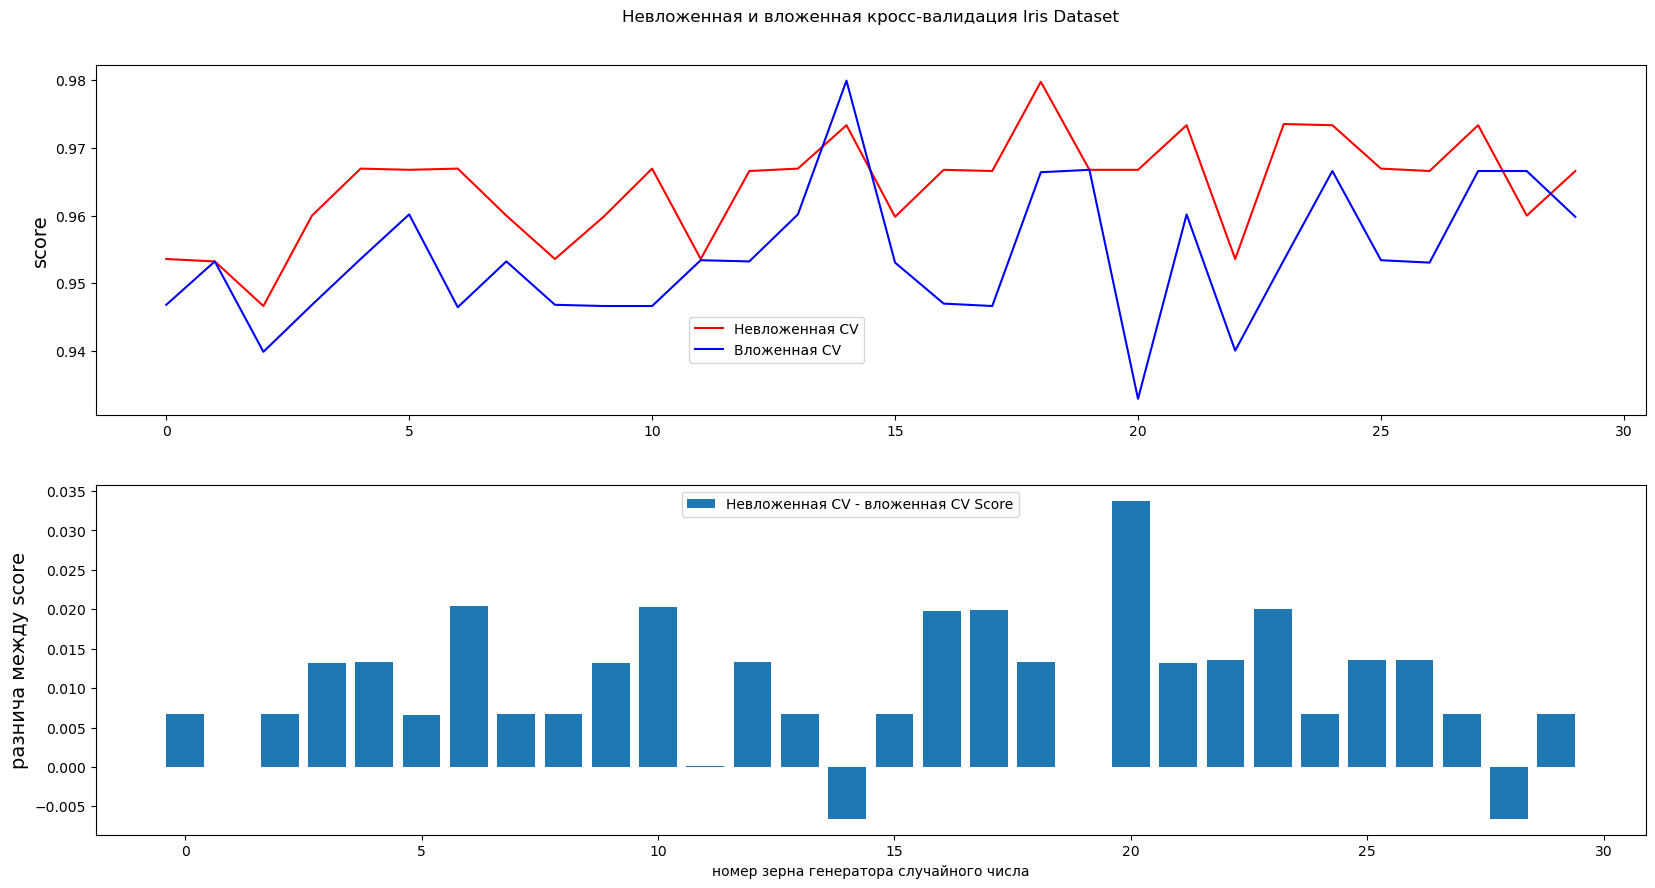

In [12]:
# Возьмем различные фиксироанные "зерна"
NUM_TRIALS = 30

#Грузим датасет
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Установим параметры для поиска оптимальных значений
p_grid = {"svc__C": [1, 10, 100], "svc__gamma": [0.01, 0.1]}

# возьмем rbf ядро в машину опорных векторов
svm = make_pipeline(StandardScaler(), SVC(kernel="rbf"))

# Списки для результатов
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Цикл для каждого "зерна"
for i in range(NUM_TRIALS):
    # Выбор методы перекрестной проверки для внутреннего и внешнего цикла
    # независимо от набора данных

    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Не вложенный CV параметров и скоринга 
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris) # clf.score(X_iris, y_iris) 
    non_nested_scores[i] = clf.best_score_

    # Вложенная CV с оптимизированными параметрами
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=inner_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Среднее {:6f} со станндартным отклонением {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# График метрики для вложенной и невложенной CV
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
                        
(non_nested_scores_line,) = ax[0].plot(non_nested_scores, color="r")
(nested_line,) = ax[0].plot(nested_scores, color="b")
ax[0].set_ylabel("score", fontsize="14")
ax[0].legend(
    [non_nested_scores_line, nested_line],
    ["Невложенная CV", "Вложенная CV"],
    bbox_to_anchor=(0, 0.3, 0.5, 0),
)
ax[0].set_title(
    "Невложенная и вложенная кросс-валидация Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="12",
)

# Plot bar chart of the difference.
difference_plot = ax[1].bar(range(NUM_TRIALS), score_difference)
ax[1].set_xlabel("номер зерна генератора случайного числа")
ax[1].legend(
    [difference_plot],
    ["Невложенная CV - вложенная CV Score"],
    bbox_to_anchor=(0, 1, 0.6, 0),
)
ax[1].set_ylabel("разнича между score", fontsize="14")

plt.show()

Внимательно посмотрите на результат решетки:

In [13]:
clf_cv = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
clf_cv.fit(X_iris, y_iris)
pd.DataFrame(clf_cv.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.00188,0.001599,0.001589,0.001419,0.001433,0.001437
std_fit_time,0.00028,0.000103,0.000138,0.000019,0.00005,0.000065
mean_score_time,0.001232,0.000956,0.000936,0.000858,0.000865,0.000848
std_score_time,0.000197,0.000035,0.000031,0.000006,0.000035,0.000019
param_svc__C,1,1,10,10,100,100
param_svc__gamma,0.01,0.1,0.01,0.1,0.01,0.1
params,"{'svc__C': 1, 'svc__gamma': 0.01}","{'svc__C': 1, 'svc__gamma': 0.1}","{'svc__C': 10, 'svc__gamma': 0.01}","{'svc__C': 10, 'svc__gamma': 0.1}","{'svc__C': 100, 'svc__gamma': 0.01}","{'svc__C': 100, 'svc__gamma': 0.1}"
split0_test_score,0.868421,0.947368,0.894737,0.947368,0.947368,0.921053
split1_test_score,0.921053,0.973684,1.0,1.0,1.0,1.0
split2_test_score,0.891892,0.918919,0.945946,0.945946,0.918919,0.945946


In [14]:
clf_cv.best_score_

0.9665718349928876

In [15]:
clf_cv.best_params_

{'svc__C': 10, 'svc__gamma': 0.1}

Обратите внимание, что ниже результаты противоречат best_score_ так как переобучились из-за refit на всем наборе. Поэтому все расчеты выше абсалютно корректны!

In [16]:
clf_cv.fit(X_iris, y_iris)
clf_cv.score(X_iris, y_iris)

0.98

In [17]:
svm_f = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1, gamma=0.1))
svm_f.fit(X_iris, y_iris)
svm_f.score(X_iris, y_iris)

0.98

Скорость кода

In [18]:
import time
n = 10
t0 = time.time()
for i in range(n):
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=inner_cv)
    nested_score.mean()
t1 = time.time()
t1-t0

4.271536111831665

In [19]:
n = 10
t0 = time.time()
for i in range(n):
    clf_cv = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf_cv.fit(X_iris, y_iris)
    clf_cv.best_score_
t1 = time.time()
t1-t0

0.7927680015563965